# Data Analysis

#### Imports

In [1]:
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 999
import sqlite3
import statsmodels.formula.api as sm
# import statsmodels.api as s
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Database Connection

In [2]:
conn = sqlite3.connect("./sample.db")

#### Occupy Dataframe

In [3]:
# df_occupy = pd.read_sql(sql="SELECT * FROM occupy", con=conn)
df_occupy_1 = pd.read_sql(sql="SELECT room, date, time, associated_client_count, authenticated_client_count FROM occupy", con=conn)
df_occupy_2 = pd.read_sql(sql="SELECT room, date, time, module_code, occupancy FROM occupy", con=conn)

#### Only consider rows with the following conditions satisfied:

* **Condition 1**: time between 9:00 and 16:00
* **Condition 2:** This condition is because we want to take the average authenticated client count between these times. We are disregarding the other figures because we are not sure of the DHCP lease duration. For instance, a number of the devices could still be being considered from an individual who has already left the room but the lease is still considered.
    - time >= quarter past the hour
    - time <= quarter past the hour

In [4]:
df_occupy_1["condition1"] = df_occupy_1["time"].apply(lambda x: "true" if 16 >= int(x[0:2]) >= 9 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition1"] == "true"]
# df_occupy_1

In [5]:
df_occupy_1["condition2"] = df_occupy_1["time"].apply(lambda x: "true" if 45 >= int(x[-2:]) >= 15 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition2"] == "true"]
# df_occupy_1

In [6]:
del df_occupy_1["condition1"]
del df_occupy_1["condition2"]
df_occupy_1["time"] = df_occupy_1["time"].apply(lambda x: x[0:3] + "00")
# df_occupy_1

In [7]:
df_occupy_2 = df_occupy_2
# df_occupy_2

In [8]:
df_occupy_merge = pd.merge(left = df_occupy_1, right = df_occupy_2, how="outer", on=["room", "date", "time"]) 
# df_occupy_merge

In [9]:
# df_occupy_merge.head(10)

In [10]:
# df_occupy_merge.tail(10)

In [11]:
df_occupy = df_occupy_merge.groupby(["room", "date", "time", "module_code"], as_index=False).mean()

In [12]:
# df_occupy["authenticated_client_count"] = df_occupy["authenticated_client_count"].round(0)
# df_occupy["associated_client_count"] = df_occupy["associated_client_count"].round(0)
print(df_occupy.shape)
# df_occupy

(172, 7)


#### Remove rows with NaN values 

In [13]:
df_occupy = df_occupy.dropna() 
print(df_occupy.shape)
# df_occupy

(153, 7)


#### Module Dataframe

In [14]:
df_module = pd.read_sql(sql="SELECT * FROM module", con=conn)
# df_module.head(10)

In [15]:
# df_module.tail(10)

#### Location Dataframe

In [16]:
df_location = pd.read_sql(sql="SELECT * FROM location", con=conn)
# df_location.head(10)

In [17]:
# df_location.tail(10)

#### Close db connection

In [18]:
conn.close()

## Construct Analytics Base Table

#### Join tables

In [19]:
df_abt = pd.merge(left = df_occupy, right = df_module, how="outer", on=["module_code"]) 
df_abt = pd.merge(left = df_abt, right = df_location, how="outer", on=["room"]) 
print(df_abt.shape)
# df_abt

(154, 11)


#### Remove rows without registered students i.e. no class

In [20]:
df_abt = df_abt[df_abt["reg_students"] != 0]
print(df_abt.shape)
# df_abt

(130, 11)


#### Add occupancy ground truth number to ABT
#### Take min between occupancy gt and reg students to remove error in gt measurement

In [21]:
df_abt["occupancy_number"] = df_abt["occupancy"] * df_abt["capacity"]
df_abt["min_occ_reg"] = df_abt.loc[:, ['occupancy_number', 'reg_students']].min(axis=1)
# df_abt

In [22]:
df_abt = df_abt.dropna() 

#### Test: Does ground truth data have more students than what is registered

In [23]:
# df_abt["reg_students_less_occ"] = df_abt["reg_students"] - df_abt["occupancy_number"]

In [24]:
# errors = df_abt[df_abt["reg_students_less_occ"] < 0]
# print(errors.shape)
# errors

* For those rows with -10, change occupancy_number to the number of registered students
* Should we disregard rows with greater difference because data should be considered to be an outlier
* Also, what to do with the rows that have 0 registered students i.e. was there a class? If not should we even consider it?......

#### Get % error 

In [25]:
# df_abt["error_perc"] = (df_abt["reg_students"] - df_abt["occupancy_number"]) / df_abt["capacity"]
# df_abt

#### Remove those with an error larger than 10%

In [26]:
# df_abt = df_abt[df_abt["error_perc"] >= -0.1]
# print(df_abt.shape)
# df_abt

#### Those with an error equal to or less than a 10% error, adjust figure to equal ground truth

In [27]:
# df_abt["adjustment"] = df_abt["reg_students_less_occ"].apply(lambda x: x if x <= 0 else 0)
# df_abt

In [28]:
# df_abt["occupancy_number_adj"] = df_abt["adjustment"] + df_abt["occupancy_number"]

#### Analysis of data with occupancy number equal to zero (NEED TO DO SOMETHING WITH THIS!!!!)

In [29]:
# a = df_abt[df_abt["occupancy_number_adj"] == 0]
# a[["module_code", "reg_students", "occupancy_number_adj", "authenticated_client_count"]]

#### Create binned associated and authenticated client counts for logistic regression

In [30]:
# def bin(r):
#     '''Bin client counts into percintle categories'''
#     if r < .125:
#         return .0
#     elif r < .375: 
#         return .25
#     elif r < .625:
#         return .5
#     elif r < .875:
#         return .75
#     else:
#         return 1.0 

# df_abt["assoc_binned"] = df_abt["associated_client_count"] / df_abt["capacity"]
# df_abt["assoc_binned"] = df_abt["assoc_binned"].apply(lambda x: bin(x))
# df_abt["auth_binned"] = df_abt["authenticated_client_count"] / df_abt["capacity"]
# df_abt["auth_binned"] = df_abt["auth_binned"].apply(lambda x: bin(x))
# df_abt

# Models

### Model 1: Simple Linear (Y: min_occ_reg, X: authenticated_client_count)

In [31]:
df_reg_1= df_abt[["min_occ_reg", "authenticated_client_count"]].copy()
# df_reg_1

### Feature Analysis

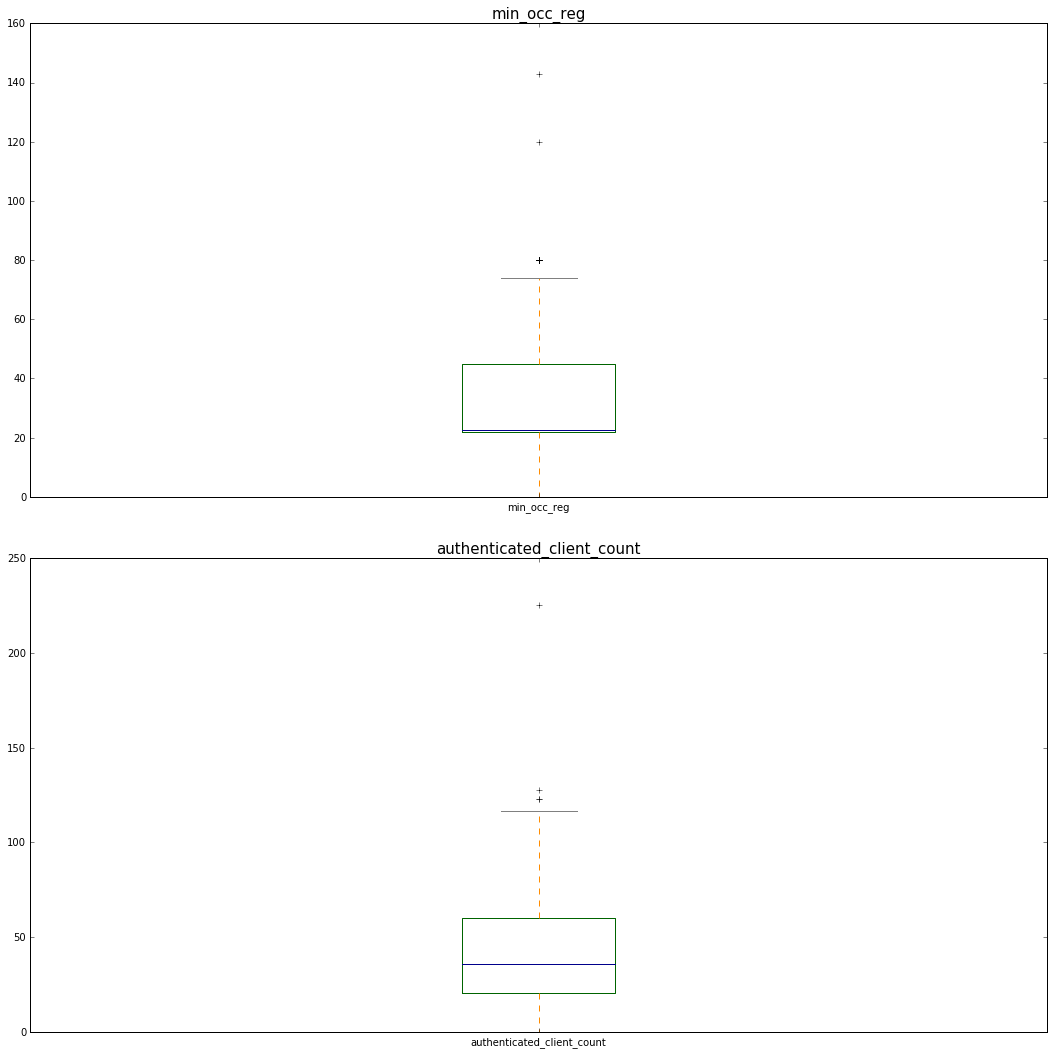

In [32]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_1["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_reg_1["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

#### Normalize Features and remove outliers (?)

In [33]:
def normalize(df, feature):
    return (df[feature] - df[feature].mean()) / df[feature].std()

df_reg_1["min_occ_reg_NORM"] = normalize(df_reg_1, "min_occ_reg")
df_reg_1["auth_client_count_NORM"] = normalize(df_reg_1, "authenticated_client_count")
print(df_reg_1.shape)
# df_reg_1

(128, 4)


In [34]:
def removeOutliers(df, feature):
    '''Remove outliers (more than 3 std devs from mean)'''
    return df[np.abs(df[feature] - df[feature].mean()) <= (3 * df[feature].std())]

df_reg_1 = removeOutliers(df_reg_1, "min_occ_reg_NORM")
df_reg_1 = removeOutliers(df_reg_1, "auth_client_count_NORM")
df_reg_1 = df_reg_1[["min_occ_reg", "authenticated_client_count"]]
print(df_reg_1.shape)
# df_reg_1

(125, 2)


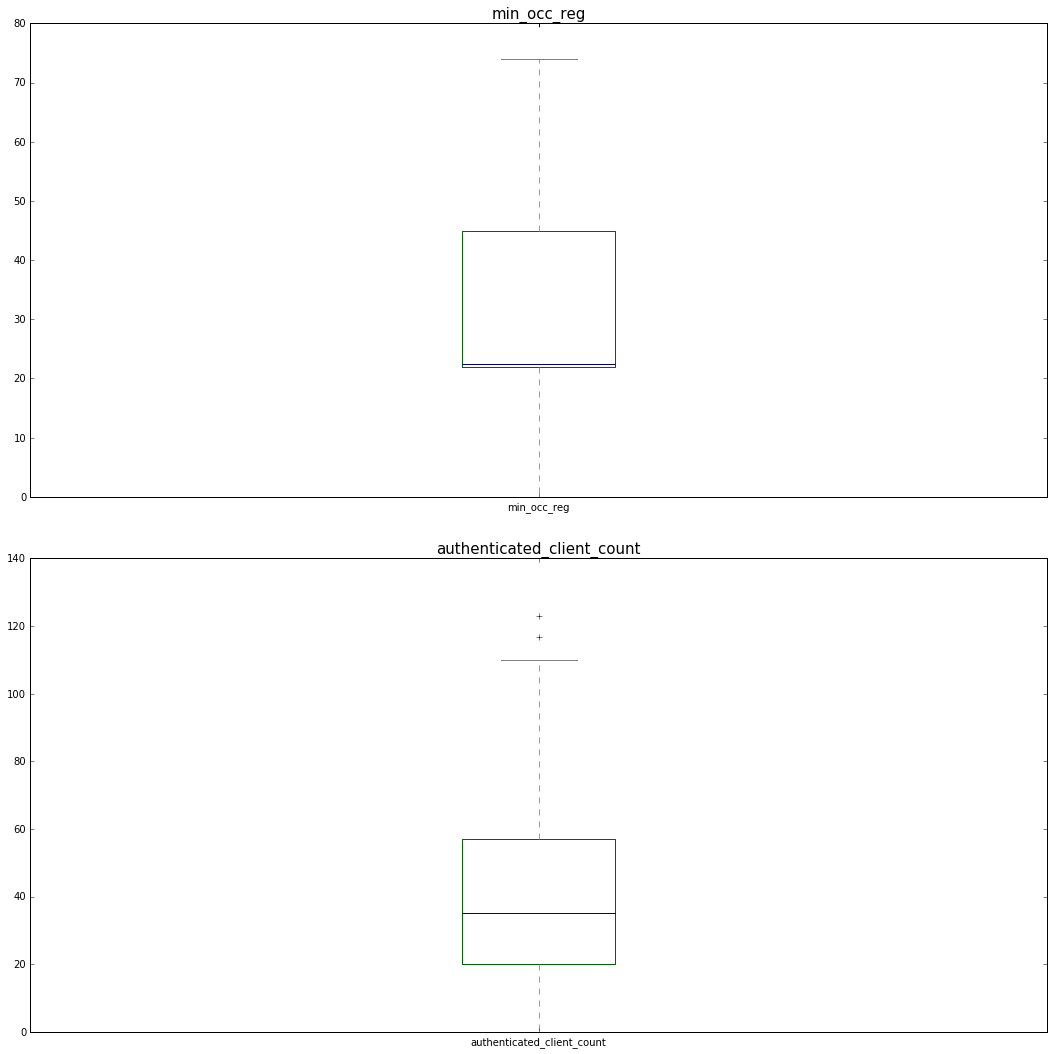

In [35]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_1["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_reg_1["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

In [36]:
print(df_reg_1.dtypes)
corrMatrix = df_reg_1.corr()
corrMatrix

min_occ_reg                   float64
authenticated_client_count    float64
dtype: object


,min_occ_reg,authenticated_client_count
min_occ_reg,1.000000,0.693793
authenticated_client_count,0.693793,1.000000


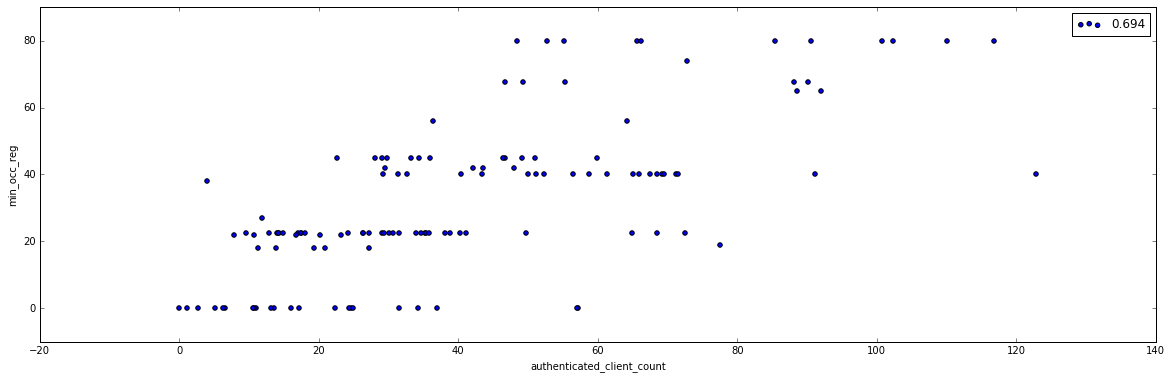

In [37]:
plt.figure() 
df_reg_1.plot(kind="scatter", x="authenticated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))
# plt.savefig("Scatter_Plot.png")

#### Statsmodels

In [38]:
lm_sm = sm.ols(formula="min_occ_reg ~ authenticated_client_count - 1", data=df_reg_1).fit()
print(lm_sm.summary())

                            OLS Regression Results                            
Dep. Variable:            min_occ_reg   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     543.5
Date:                Wed, 03 Aug 2016   Prob (F-statistic):           3.74e-47
Time:                        14:01:59   Log-Likelihood:                -533.62
No. Observations:                 125   AIC:                             1069.
Df Residuals:                     124   BIC:                             1072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
authenticated_client

#### Scikit Learn

Coefficients: 
 [ 0.60086851]
Intercept: 
 7.88177302973
Residual sum of squares: 280.40
Square Root of Residual sum of squares: 16.75
Variance score: 0.48


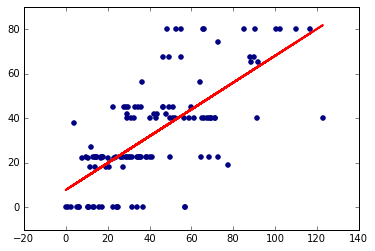

In [39]:
X = df_reg_1["authenticated_client_count"].reshape(len(df_reg_1["authenticated_client_count"]), 1)
y = df_reg_1["min_occ_reg"]

lm_scikit_1 = LinearRegression()

# Fit the model 
lm_scikit_1.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_1.coef_)
# The intercept
print('Intercept: \n', lm_scikit_1.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_1.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_1.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_1.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_1.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

In [40]:
# print(lm_scikit.predict(X))

In [41]:
# df_reg_1["predicted_occupancy"] = pd.Series(lm_scikit_1.predict(X), index=df_reg_1.index)
# df_reg_1

### Train & Testing

#### Cross Validation

In [42]:
R2_scores_1 = cross_val_score(lm_scikit_1.fit(X, y), X.astype(int), y.astype(int), cv=5, scoring="r2")
print(R2_scores_1)

[ 0.24550165 -0.08107307  0.28460772  0.4503266   0.32127097]


#### Train and test 

(87, 1)
(87,)
(38, 1)
(38,)
Coefficients: 
 [ 0.6154115]
Intercept: 
 6.27640873633
Residual sum of squares: 334.04
334.042045109
18.2768171493
Variance score: 0.37


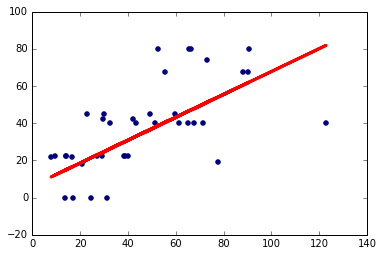

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

lm_scikit_1_t = LinearRegression()

# Train the model using the training sets
lm_scikit_1_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit_1_t.coef_)
# The intercept
print('Intercept: \n', lm_scikit_1_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % np.mean((lm_scikit_1_t.predict(X_test) - y_test) ** 2))
print(metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test)))
print(np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_1_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_1_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

In [44]:
# plt.scatter(lm_scikit.predict(X_train), lm_scikit.predict(X_train) - y_train, color="navy", s=40, alpha=0.5)
# plt.scatter(lm_scikit.predict(X_test), lm_scikit.predict(X_test) - y_test, color="green", s=40)
# plt.hlines(y=0, xmin=0, xmax=160)
# plt.title("Residual Plot: training (Navy) and test (Green) data")
# plt.ylabel("Residuals")

### Model 2: Simple Linear (Y: min_occ_reg, X: asso_client_count)

In [45]:
df_reg_2= df_abt[["min_occ_reg", "associated_client_count"]].copy()
# df_reg_2

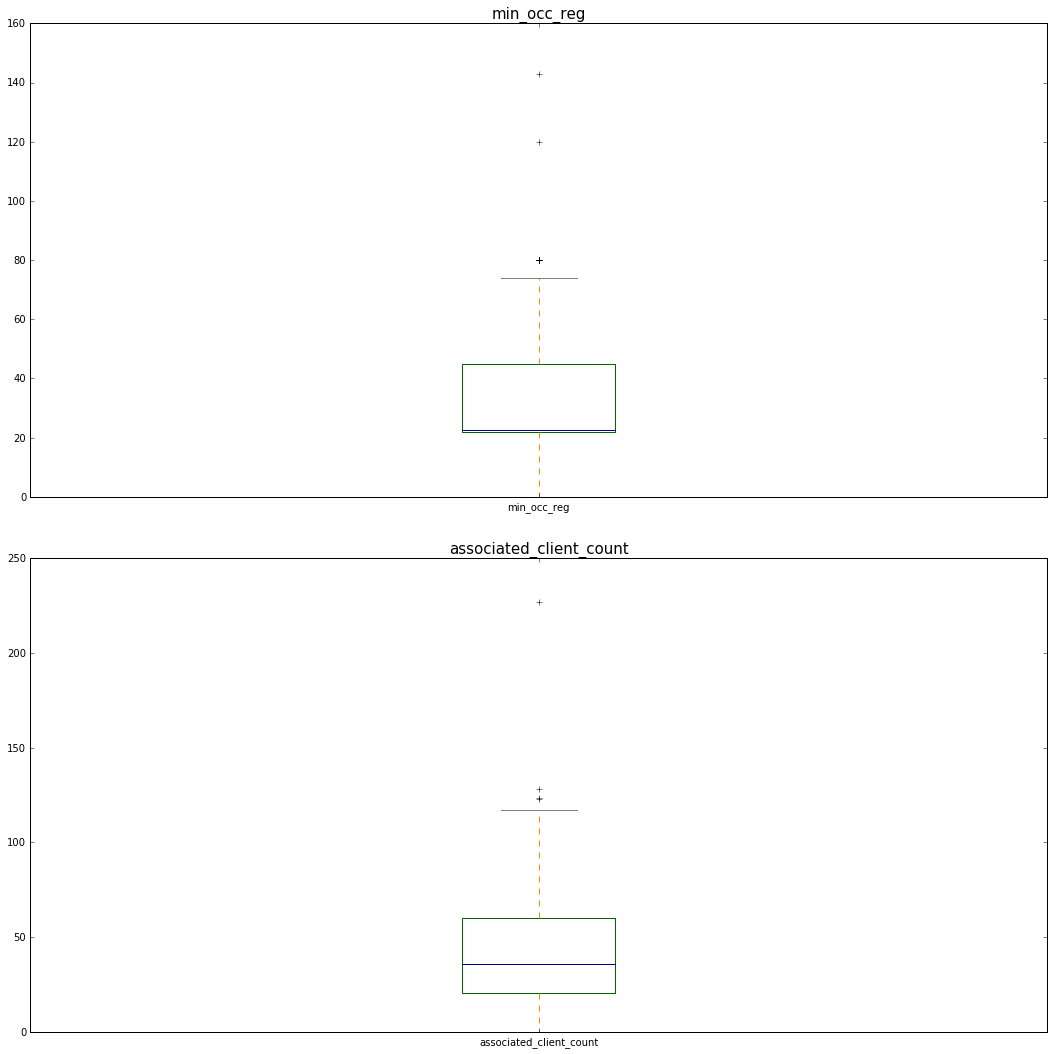

In [46]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_2["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("associated_client_count", fontsize=15)
df_reg_2["associated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

In [47]:
df_reg_2["min_occ_reg_NORM"] = normalize(df_reg_2, "min_occ_reg")
df_reg_2["asso_client_count_NORM"] = normalize(df_reg_2, "associated_client_count")
print(df_reg_2.shape)
# df_reg_2

(128, 4)


In [48]:
df_reg_2 = removeOutliers(df_reg_2, "min_occ_reg_NORM")
df_reg_2 = removeOutliers(df_reg_2, "asso_client_count_NORM")
df_reg_2 = df_reg_2[["min_occ_reg", "associated_client_count"]]
print(df_reg_2.shape)
# df_reg_2

(125, 2)


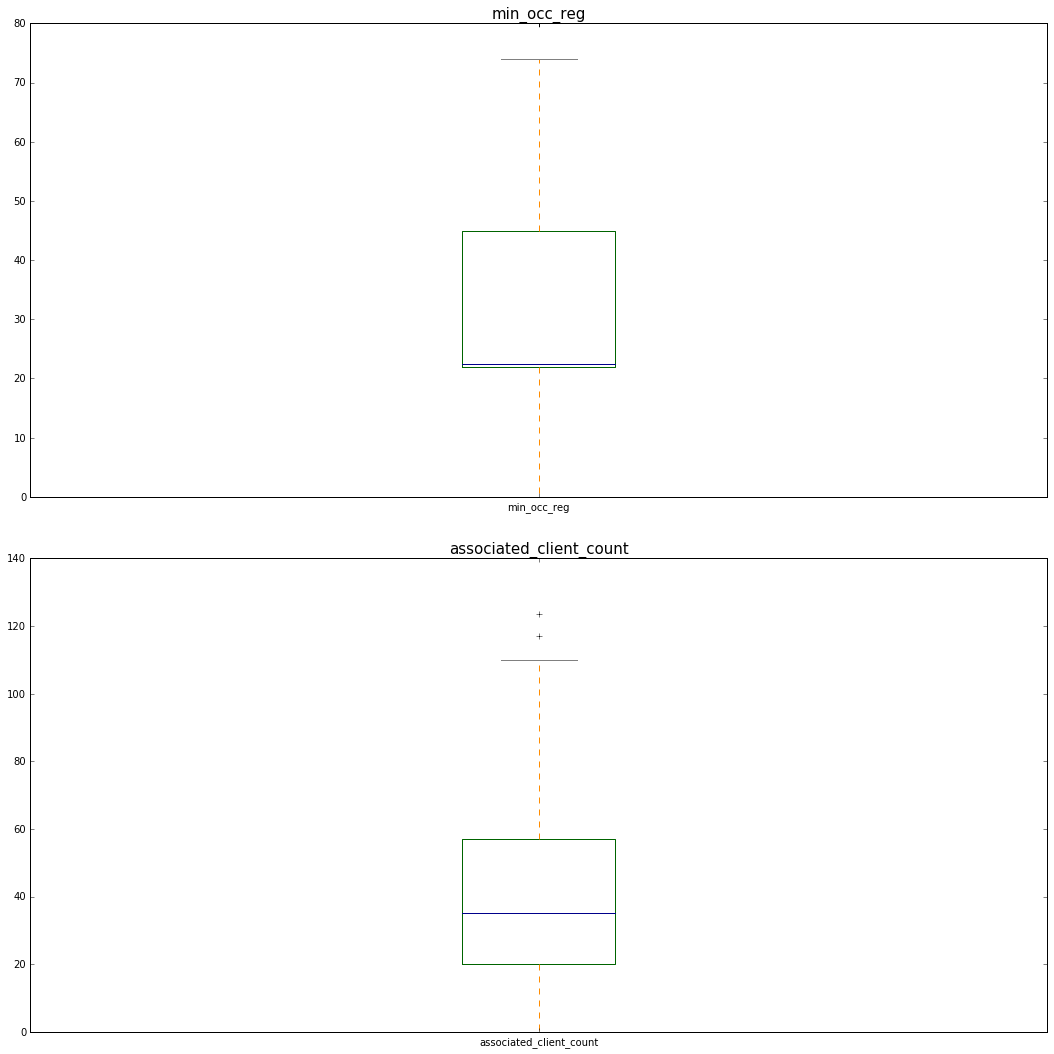

In [49]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_2["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("associated_client_count", fontsize=15)
df_reg_2["associated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

In [50]:
print(df_reg_2.dtypes)
corrMatrix = df_reg_2.corr()
corrMatrix

min_occ_reg                float64
associated_client_count    float64
dtype: object


,min_occ_reg,associated_client_count
min_occ_reg,1.000000,0.693639
associated_client_count,0.693639,1.000000


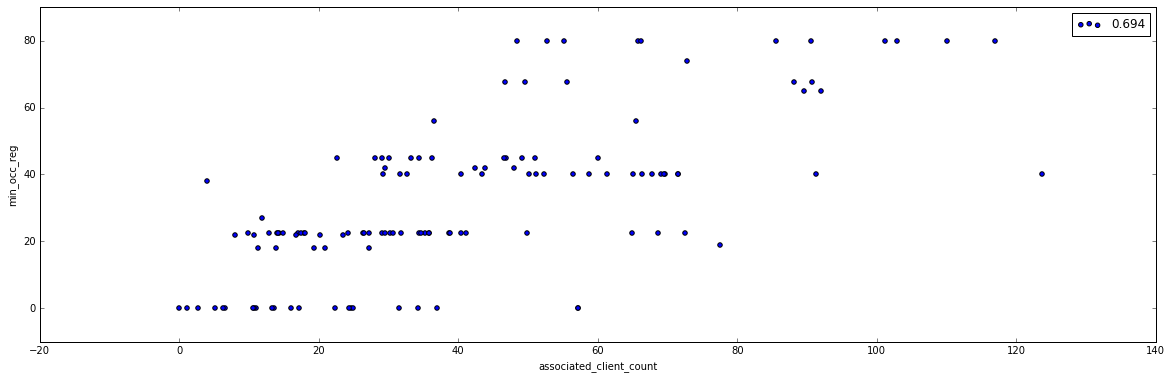

In [51]:
plt.figure() 
df_reg_2.plot(kind="scatter", x="associated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))
# plt.savefig("Scatter_Plot.png")

In [52]:
lm_sm_2 = sm.ols(formula="min_occ_reg ~ associated_client_count - 1", data=df_reg_2).fit()
print(lm_sm_2.summary())

                            OLS Regression Results                            
Dep. Variable:            min_occ_reg   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     543.1
Date:                Wed, 03 Aug 2016   Prob (F-statistic):           3.91e-47
Time:                        14:02:01   Log-Likelihood:                -533.66
No. Observations:                 125   AIC:                             1069.
Df Residuals:                     124   BIC:                             1072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
associated_client_count   

Coefficients: 
 [ 0.59885264]
Intercept: 
 7.89820771409
Residual sum of squares: 280.51
280.513773781
16.7485454229
Variance score: 0.48


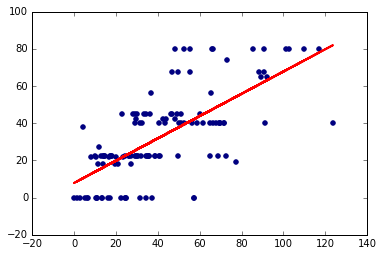

In [53]:
X = df_reg_2["associated_client_count"].reshape(len(df_reg_2["associated_client_count"]), 1)
y = df_reg_2["min_occ_reg"]

lm_scikit_2 = LinearRegression()

# Fit the model 
lm_scikit_2.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_2.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % np.mean((lm_scikit_2.predict(X) - y) ** 2))
print(metrics.mean_squared_error(y, lm_scikit_2.predict(X)))
print(np.sqrt(metrics.mean_squared_error(y, lm_scikit_2.predict(X))))

# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_2.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_2.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

In [54]:
R2_scores_2 = cross_val_score(lm_scikit_2.fit(X, y), X.astype(int), y.astype(int), cv=5)
print(R2_scores_2)

[ 0.24260432 -0.07764585  0.28032236  0.45079952  0.32430428]


(87, 1)
(87,)
(38, 1)
(38,)
Coefficients: 
 [ 0.65145334]
Intercept: 
 5.30323135058
Residual sum of squares: 338.51
338.513538587
18.3987374183
Variance score: 0.34


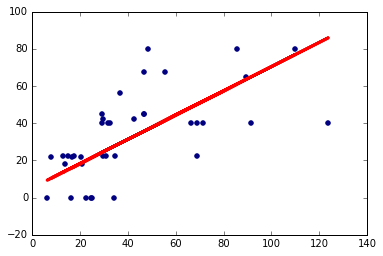

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

lm_scikit_2_t = LinearRegression()
# Train the model using the training sets
lm_scikit_2_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit_2_t.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % np.mean((lm_scikit_2_t.predict(X_test) - y_test) ** 2))
print(metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test)))
print(np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_2_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_2_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

#### Normalize

In [56]:
def convert_perc_int(df):
    ''''''
    df["occupancy"] = df["occupancy"].apply(lambda x: x * 100)
    return df

In [57]:
df = df_abt[["occupancy", "authenticated_client_count"]].copy()
df = convert_perc_int(df)

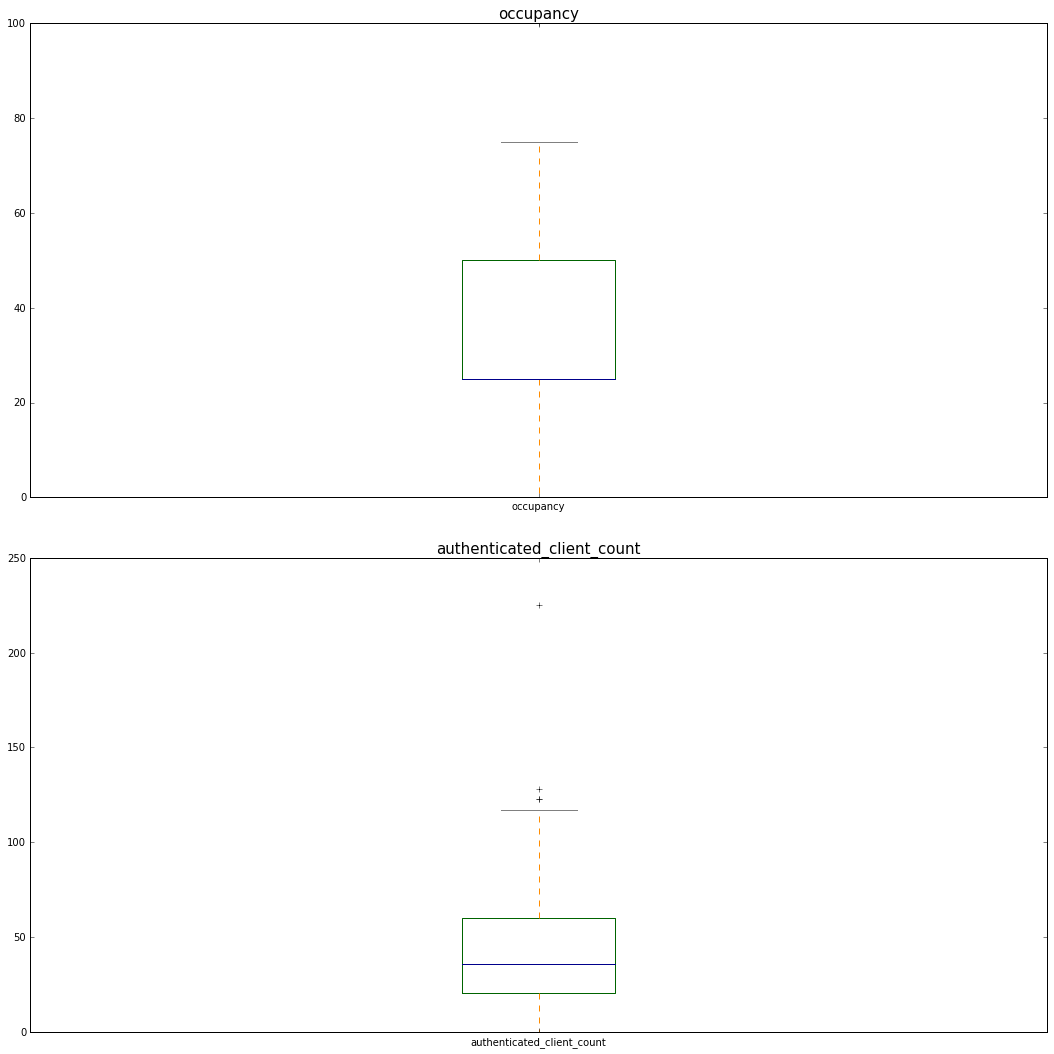

In [58]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("occupancy", fontsize=15)
df["occupancy"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

In [67]:
df["occupancy_NORM"] = normalize(df, "occupancy")
df["authenticated_client_count_NORM"] = normalize(df, "authenticated_client_count")
print(df.shape)

df = removeOutliers(df, "occupancy_NORM")
df = removeOutliers(df, "authenticated_client_count_NORM")
df = df[["occupancy", "authenticated_client_count"]]
print(df.shape)

(127, 4)
(127, 2)


### Logistic Regression http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

In [60]:
df_log_1 = df.copy()
X = df_log_1["authenticated_client_count"].reshape(len(df_log_1["authenticated_client_count"]), 1)
y = df_log_1["occupancy"]
lr = LogisticRegression()
lr.fit(X.astype(int), y.astype(int))
pred_lr = lr.predict(X)
print(metrics.classification_report(y.astype(int), pred_lr))
print(metrics.confusion_matrix(y.astype(int), pred_lr))

             precision    recall  f1-score   support

          0       1.00      0.14      0.24        22
         25       0.52      0.97      0.68        63
         50       0.57      0.12      0.21        32
         75       0.00      0.00      0.00        10

avg / total       0.58      0.54      0.43       127

[[ 3 19  0  0]
 [ 0 61  2  0]
 [ 0 28  4  0]
 [ 0  9  1  0]]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
df_log_1["predicted"] = pd.Series(pred_lr, index=df_log_1.index)

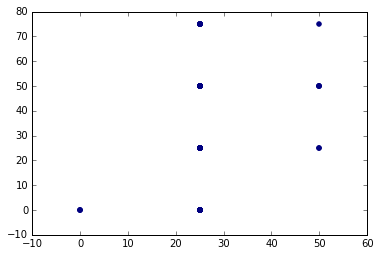

In [62]:
plt.scatter(df_log_1["predicted"], df_log_1["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

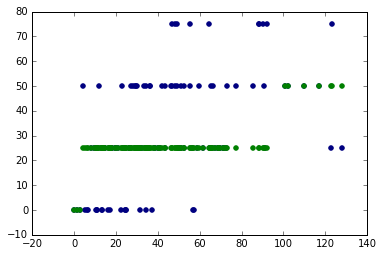

In [63]:
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["occupancy"],  color='navy')
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Gaussian Naive Bayes 

In [64]:
df_gnb = df.copy()
df_gnb = convert_perc_int(df_gnb)
X = df_gnb["authenticated_client_count"].reshape(len(df_gnb["authenticated_client_count"]), 1)
y = df_gnb["occupancy"]
# fit a Naive Bayes model to the data
gnb = GaussianNB()
gnb.fit(X, y)
pred_gnb = gnb.predict(X)
print(metrics.classification_report(y, pred_gnb))
print(metrics.confusion_matrix(y, pred_gnb))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        22
       25.0       0.53      0.95      0.68        63
       50.0       0.50      0.16      0.24        32
       75.0       0.25      0.10      0.14        10
      100.0       1.00      1.00      1.00         1

avg / total       0.41      0.52      0.41       128

[[ 0 22  0  0  0]
 [ 0 60  1  2  0]
 [ 0 26  5  1  0]
 [ 0  5  4  1  0]
 [ 0  0  0  0  1]]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
df_gnb["predicted"] = pd.Series(pred_gnb, index=df_log_1.index)

ValueError: Wrong number of items passed 128, placement implies 127

In [ ]:
plt.scatter(df_gnb["predicted"], df_gnb["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["occupancy"],  color='navy')
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### k-Nearest Neighbor

In [ ]:
df_nn = df.copy()
df_nn = convert_perc_int(df_nn)
X = df_nn["authenticated_client_count"].reshape(len(df_nn["authenticated_client_count"]), 1)
y = df_nn["occupancy"] 
nn = KNeighborsClassifier()
nn.fit(X, y)
pred_nn = nn.predict(X)
print(metrics.classification_report(y, pred_nn))
print(metrics.confusion_matrix(y, pred_nn))

In [ ]:
df_nn["predicted"] = pd.Series(pred_nn, index=df_log_1.index)

In [ ]:
plt.scatter(df_nn["predicted"], df_nn["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_nn["authenticated_client_count"], df_nn["occupancy"],  color='navy')
plt.scatter(df_nn["authenticated_client_count"], df_nn["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Support Vector Machines

In [ ]:
df_svm = df.copy()
df_svm = convert_perc_int(df_svm)
X = df_svm["authenticated_client_count"].reshape(len(df_svm["authenticated_client_count"]), 1)
y = df_svm["occupancy"] 
svc = SVC()
svc.fit(X, y)
pred_svm = svc.predict(X)
print(metrics.classification_report(y, pred_svm))
print(metrics.confusion_matrix(y, pred_svm))

In [ ]:
df_svm["predicted"] = pd.Series(pred_svm, index=df_log_1.index)

In [ ]:
plt.scatter(df_svm["predicted"], df_svm["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_svm["authenticated_client_count"], df_svm["occupancy"],  color='navy')
plt.scatter(df_svm["authenticated_client_count"], df_svm["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()